## Structure of the notebook 

### I. Creating the dataset.
### II. Sentiment analysis using RoBERTa.
### III. Data analysis in terms of type of seat.
#### 1. Counting how many cases of each sentiment class we have for each type of seat.
#### 2. Negative and positive word clouds for each type of seat.
#### 3. The type of seat with the highest level of dissatisfaction.
#### 4. The type of seat with the highest level of satisfaction.
###  IV. Data analysis in terms of type of traveler .
#### 1. Counting how many cases of each sentiment class we have for each type of traveler.
#### 2. Negative and positive word clouds for each type of traveler.
#### 3. The type of traveler with the highest level of dissatisfaction.
#### 4. The type of traveler with the highest level of satisfaction.
###  V. A Cross-tabulation of the variables “type of seat” and “type of traveler” with an aggregation of the ratings.




In [1]:
from bs4 import BeautifulSoup
from lxml import html
import requests
from wordcloud import WordCloud
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
from scipy.special import softmax


### I. Creating the dataset 

In [2]:
# The Xpath for the different elements that we will scrape
rating_xpath = '//div[contains(@itemprop, "reviewRating")]/span[contains(@itemprop, "ratingValue")]'
header_xpath = '//div[contains(@class, "body")]/h2[contains(@class, "text_header")]'
rev_date_xpath = '//div[contains(@class, "body")]//time[contains(@itemprop, "datePublished")]/@datetime'
verfiyed_xpath = '//div[contains(@class, "text_content")]/strong/a/em'
review_cont_xpath = '//article[contains(@itemprop, "review")]//div[contains(@class, "text_con")]'
type_of_traveler_xpath = '//tr/td[contains(@class, "review-rating-header type_of_traveller ")]/following-sibling::td/text()'
type_of_seat_xpath = '//tr/td[contains(@class, "review-rating-header cabin_flown ")]/following-sibling::td/text()'
route_path_xpath = '//tr/td[contains(@class, "review-rating-header route ")]/following-sibling::td/text()'
date_flight_xpath = '//tr/td[contains(@class, "review-rating-header date_flown ")]/following-sibling::td/text()'


In [3]:
ratings = []
headers = []
rev_date = []
verif = []
reviews = []
type_of_trav = []
type_of_seat = []
routes = []
flt_date = []
complete_pages = []

for i in range(1, 36):
    URL = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/?sortby=post_date%3ADesc&pagesize=100".format(i)

    page = requests.get(URL)
    tree = html.fromstring(page.content)
    
    # Getting the ratings
    rt = tree.xpath(rating_xpath)
    
    # Getting the headers
    hd = tree.xpath(header_xpath)
    
    # Getting the dates
    dt_rv = tree.xpath(rev_date_xpath)
    
    #  Getting verifications
    vr_f = tree.xpath(verfiyed_xpath)
    
    # Getting the review content
    cont = list(tree.xpath(review_cont_xpath)[0])
    
    # Getting type of traveler 
    trav_tp = tree.xpath(type_of_traveler_xpath)
    
    # Getting type of seat
    seat_tp = tree.xpath(type_of_seat_xpath)
    
    # Getting the routes 
    route = tree.xpath(route_path_xpath)
    
    # Getting flight date
    fl_dt = tree.xpath(date_flight_xpath)
    
    rev = []
    
    # Code for cleaning the reviews.
    for j in tree.xpath(review_cont_xpath)[0].xpath('//text()'):
        if ' | ' in j and '{"@context' not in j and '[]' not in j and 'Air Travel Ratings &' not in j:
            rev.append(j)
    # Code to make sure we get only complete reviews with no missing data. 
    if len(rt)==len(rev) and len(rt)==len(route) and len(rt)==len(trav_tp):
        ratings = ratings + rt
        headers = headers + hd
        rev_date = rev_date + dt_rv
        verif = verif + vr_f
        reviews = reviews + rev
        type_of_trav = type_of_trav + trav_tp
        type_of_seat = type_of_seat + seat_tp
        routes = routes + route
        flt_date = flt_date + fl_dt
        complete_pages.append(i)

In [253]:
len(flt_date)

1100

In [254]:
# Getting the pages with correct 100 reviews
complete_pages

[2, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15]

In [263]:
# Getting the ratings 
ratings_ct = []
for i in range(len(ratings)):
    ratings_ct.append(int(ratings[i].text))

In [418]:
ratings_ct[0]

1

In [271]:
# Getting the headers
headers_ct = []
for i in range(len(headers)):
    headers_ct.append(str(headers[i].text).strip('""'))

In [419]:
headers_ct[0]

'battling a long overdue refund'

In [296]:
# Getting the reviews 
reviews_ct = []
for i in range(len(reviews)):
    reviews_ct.append(reviews[i].strip(' | '))


In [420]:
reviews_ct[0]

"I have been battling a long overdue refund with BA regarding a flight originally booked in 2019... The flight was cancelled, a voucher was issued, another flight was booked using this voucher, and then again cancelled. After trying to use the voucher for a new flight, BA kept advising I couldn't as the voucher had been used. I asked them to check the status of that flight (as it never left) and the agent advised she didn't have access to that information. Two years in, I managed to speak to someone who recognised that either a voucher or refund was due and made a note on my record. I then decided to pursue a refund, as felt this would be less problematic. BA have acknowledged they owe me a refund. One phone call they said it will be with me in 18 working days. I then chased when it was long overdue. I was then told it will be with me in 21 working days. The refund never came. I try regularly to get through to Customer Service for the automated system to advise no agents are available.

In [311]:
import pandas as pd
df_BA = pd.DataFrame({'ratings':ratings_ct, 'headers':headers_ct, 'review_date':rev_date, 'review':reviews_ct, 'traveler_type':type_of_trav, 'seat_type':type_of_seat, 'routes':routes, 'flight_date':flt_date})
df_BA

,ratings,headers,review_date,review,traveler_type,seat_type,routes,flight_date
0,1,battling a long overdue refund,2022-05-18,I have been battling a long overdue refund wit...,Solo Leisure,Economy Class,London to Geneva,March 2022
1,1,I will never fly with them again,2022-05-18,"When I tried to check in, they required a cert...",Solo Leisure,Business Class,London to Mauritius,March 2022
2,3,one excuse after another with BA these days,2022-05-18,Another dreadful mediocre experience with BA t...,Solo Leisure,Economy Class,London Heathrow to Malaga,May 2022
3,2,Cancelled connection flight,2022-05-11,Basel to Johannesburg via London. Cancelled co...,Solo Leisure,Economy Class,Basel to Johannesburg via London,May 2022
4,4,no cabin divider in the aircraft,2022-05-11,Very low standards for Club Europe: there was ...,Couple Leisure,Business Class,Athens to London,May 2022
...,...,...,...,...,...,...,...,...
1095,2,worst airline I have ever flown,2017-03-11,London Heathrow to Las Vegas. Never had need t...,Solo Leisure,Economy Class,London to Las Vegas,March 2017
1096,3,cutbacks are a cut too far,2017-03-11,Gatwick to Bridgetown. Firstly couldn't book m...,Couple Leisure,Economy Class,Gatwick to Bridgetown,February 2017
1097,5,experience was a bit shoddy,2017-03-10,"Flew Gatwick to San Jose, Costa Rica return wi...",Couple Leisure,Economy Class,San Jose to Gatwick,February 2017
1098,1,not worth paying for business,2017-03-10,Orlando to London. I had booked business class...,Business,Business Class,Orlando to London,March 2017


In [312]:
df_BA.to_csv('BA_dataset.csv')

In [324]:
# Getting all the reviews 
all_reviews = []
htmls = []
for i in range(1, 36):
    URL = "https://www.airlinequality.com/airline-reviews/british-airways/page/{}/?sortby=post_date%3ADesc&pagesize=100".format(i)

    page = requests.get(URL)
    tree_reviews = html.fromstring(page.content)
    
    rev_list = []
    
    html_obj = tree_reviews.xpath(review_cont_xpath)
    htmls.append(html_obj[0])


In [416]:
# Getting the reviews
all_rev = []

for u in range(len(htmls)):
    for l in htmls[u].xpath('//text()'):
        rv = []
        if '{' not in l and len(l)>238:
            rv.append(l)
        all_rev = all_rev+rv

In [417]:
len(all_rev)

3479

In [421]:
# stripping ' | '
all_rev_str = []
for i in all_rev:
    all_rev_str.append(i.strip(' | '))

In [422]:
all_rev_str[0]

'Worst experience ever. Outbound flight was cancelled and I was not notified. I was rebooked on a very uncomfortable trip. Inbound flight delayed 1 hour, also not notified. On top of it, they boarded my hand luggage, which was the only bag I had. Extra wait in Milan then. Food is horrible.'

In [423]:
# Creating and saving the reviews dataframe 
df_reviews_ba = pd.DataFrame({'reviews':all_rev_str})
df_reviews_ba

,reviews
0,Worst experience ever. Outbound flight was can...
1,"Check in was a shambles at BWI, just 3 counter..."
2,Beyond disgusted with the fact that my baggage...
3,On July 19th 2022 I had submitted a complaint ...
4,"I booked the flight on Oct 8, but have to canc..."
...,...
3474,"is the flag carrier of the United Kingdom, wit..."
3475,Branded as Club World for long haul and Club E...
3476,British Airways offers a premium economy cabin...
3477,British Airways has been reducing economy clas...


In [424]:
# Saving the dataset.
df_reviews_ba.to_csv('df_all_reviews_BA.csv')

### II. Sentiment analysis using RoBERTa

In [ ]:
# Loading the model.
weights = f"cardiffnlp/twitter-roberta-base-sentiment"
tok = AutoTokenizer.from_pretrained(weights)
model = TFAutoModelForSequenceClassification.from_pretrained(weights)
model.save_pretrained(weights)


In [548]:
def predict_class(text, model_output):
    """ 
    A function to output the probability score for a given sentiment or the sentiment class.
    
    Inputs:
    ---------
    
     - text : The text for which we want to compute the sentiment score or the class
     - model_output : One of the following strings to get their probability score ['positive', 'negative', 'neutral']
                      or 'class' to the get the predicted sentiment.
    Outputs :
    ---------
    
    - Probability score for the sentiment in question or the sentiment class.
    
    """
    enc = tok(text, return_tensors='tf', padding='max_length')
    output = model(**enc)
    prob = softmax(output[0][0])
    if model_output == 'positive':
        return prob[-1]
    elif model_output == 'neutral':
        return prob[1]
    elif model_output == 'negative':
        return prob[0]
    elif model_output == 'class':
        return np.argmax(prob)
   

In [ ]:
# Predicting the probability of the positive class and the sentiment class for
# all examples.
df_BA['prob_positive'] = [predict_class(i[0:510], 'positive') for i in list(df_BA['review'].values)]
df_BA['sent_class'] = [predict_class(i[0:510], 'class') for i in list(df_BA['review'].values)]


In [4]:
# Evaluating the performance of the model.
df_DataFrame(df_BA.groupby(['sent_class'])['ratings'].mean())

NameError: name 'df_DataFrame' is not defined

We can see that the model did a decent job in classifying a large number of  positive and negative reviews, but not a good job in distinguishing neutral reviews.


In [556]:
# Investigating the ratings of the neutral class
df_BA[df_BA["sent_class"]== 1]['ratings'].describe()

count    134.000000
mean       3.626866
std        2.556641
min        1.000000
25%        1.000000
50%        3.000000
75%        6.000000
max       10.000000
Name: ratings, dtype: float64

We can see that we have at least two examples that were incorrectly classified as neutral, one example with a rating of 10(positive) and another one with a rating of 1 (negative)


In [569]:
# Fixing the mistakes of the model by setting the value of sent_class to 0 (negative)
# for examples that have a rating less than 5 and were classified as neutral by the model.

df_BA.loc[(df_BA["ratings"] < 5) & (df_BA['sent_class']==1), 'sent_class'] = 0 

In [572]:
# Verify the execution of the correction.

df_BA.loc[(df_BA["ratings"] < 5) & (df_BA['sent_class']==1), 'sent_class']

Series([], Name: sent_class, dtype: int64)

In [577]:
# Fixing the mistakes of the model by setting the value of sent_class to 2 (positive)
# for examples that have a rating greater than 5 and were classified as neutral by the model.

df_BA.loc[(df_BA["ratings"] > 5) & (df_BA['sent_class']==1), 'sent_class'] = 2 

In [578]:
# Verify the execution of the correction.

df_BA.loc[(df_BA["ratings"] > 5) & (df_BA['sent_class']==1), 'sent_class']

Series([], Name: sent_class, dtype: int64)

In [800]:
# Fixing the mistakes of the model by setting the value of sent_class to 2 (positive)
# for examples that have a rating greater than 5 and were classified as negative(0) by the model.

df_BA.loc[(df_BA["ratings"] > 5) & (df_BA['sent_class']==0), 'sent_class'] = 2

In [801]:
# Verify the execution of the correction.

df_BA.loc[(df_BA["ratings"] > 5) & (df_BA['sent_class']==0), 'sent_class']

Series([], Name: sent_class, dtype: int64)

In [802]:
# Fixing the mistakes of the model by setting the value of sent_class to 0 (negative)
# for examples that have a rating less than 5 and were classified as positive(0) by the model.

df_BA.loc[(df_BA["ratings"] < 5) & (df_BA['sent_class']==2), 'sent_class'] = 0

In [803]:
# Verifiy the execution of the correction.

df_BA.loc[(df_BA["ratings"] < 5) & (df_BA['sent_class']==2), 'sent_class']

Series([], Name: sent_class, dtype: int64)

In [804]:
# Evaluating the performance of the model after correcting the mistakes done by the model.

df_BA.groupby(['sent_class'])['ratings'].mean()

sent_class
0    2.100000
1    5.000000
2    8.025773
Name: ratings, dtype: float64

Now, the average rating for the neutral class is 5 which is the most representative rating for a neutral review.

In [805]:
# Replacing the values of the 'sent_class' column
dict_ = {0:'negative',
        1: 'neutral',
        2: 'positive'}
df_BA['sentiment'] = df_BA['sent_class'].replace(dict_)
df_BA['sentiment'].head()

0    negative
1    negative
2    negative
3    negative
4    negative
Name: sentiment, dtype: object

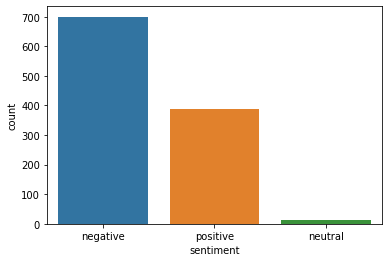

In [806]:
# Counting the cases for each sentiment
sns.countplot(x='sentiment', data=df_BA)
plt.show()

### III. Data analysis in terms of type of seat.

In [807]:
seats = list(df_BA.seat_type.unique())
seats

['Economy Class', 'Business Class', 'Premium Economy', 'First Class']

#### 1. Counting how much cases of each sentiment class we have for each type of seat.


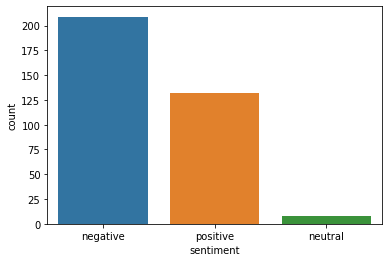

In [808]:
# the case of the business class

sns.countplot(x='sentiment', data=df_BA[df_BA['seat_type'] == 'Business Class'], order=['negative', 'positive', 'neutral'])
plt.show()


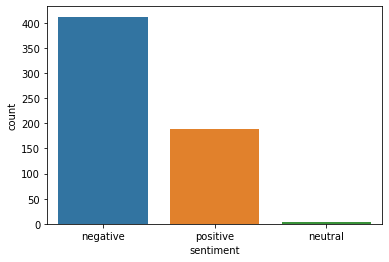

In [809]:
# The case of the economy class

sns.countplot(x='sentiment', data=df_BA[df_BA['seat_type'] == 'Economy Class'], order=['negative', 'positive', 'neutral'])
plt.show()

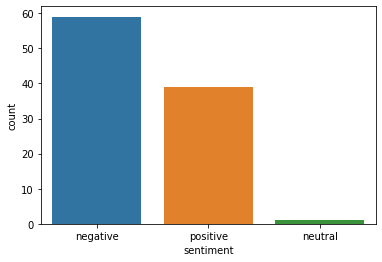

In [810]:
# The case of the premium economy class

sns.countplot(x='sentiment', data=df_BA[df_BA['seat_type'] == 'Premium Economy'], order=['negative', 'positive', 'neutral'])
plt.show()

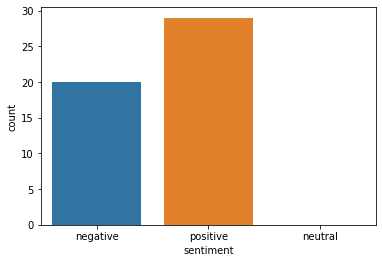

<Figure size 432x288 with 0 Axes>

In [842]:
# The case of the first class
sns.countplot(x='sentiment', data=df_BA[df_BA['seat_type'] == 'First Class'], order=['negative', 'positive', 'neutral'])
plt.show()
plt.savefig('num_pos_rev.png')


#### 2. Negative and positive wordclouds for each type of seat

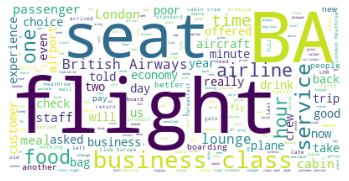

In [812]:
# Word cloud for business class 
# Negative sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'Business Class') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

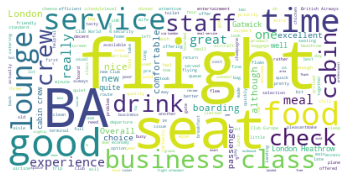

In [813]:
# Wordcloud for business class 
# Positive sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'Business Class') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

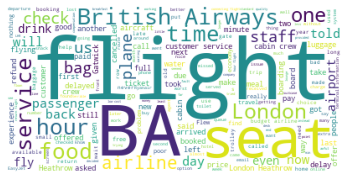

In [814]:
# Wordcloud for economy class 
# negative sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'Economy Class') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

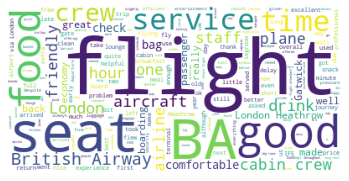

In [815]:
# Wordcloud for economy class 
# positive sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'Economy Class') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

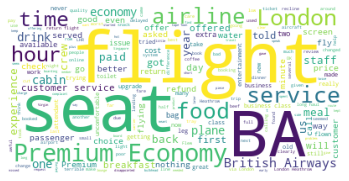

In [816]:
# Wordcloud for premium economy 
# negative sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'Premium Economy') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

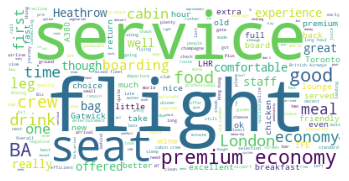

In [817]:
# Wordcloud for premium economy 
# positive sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'Premium Economy') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

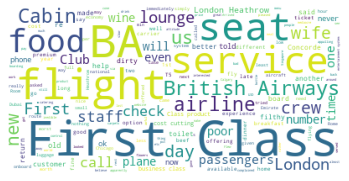

In [818]:
# Wordcloud for first class 
# negative sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'First Class') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

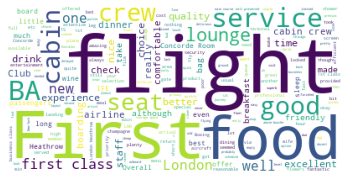

In [819]:
# Wordcloud for first class 
# positive sentiment.
bc_df = df_BA[(df_BA['seat_type'] == 'First Class') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(bc_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 3. The type of seat with the highest level of unsatisfaction


In [820]:
# Getting the dataframe
neg_df = pd.DataFrame(df_BA[df_BA.sentiment == 'negative'].groupby(['seat_type'])['sentiment'].count()).reset_index()

# normalizing the counts to neutralize the effect of the number of examples for each class

# Getting the number of examples for the economy class
num_econ = df_BA[df_BA['seat_type']=='Economy Class'].shape[0]

# Getting the number of examples for the business class
num_bus = df_BA[df_BA['seat_type']=='Business Class'].shape[0]

# Getting the number of examples for the first class
num_first = df_BA[df_BA['seat_type']=='First Class'].shape[0]

# Getting the number of examples for the premium economy
num_prem = df_BA[df_BA['seat_type']=='Premium Economy'].shape[0]

# normlized count for business class
neg_df.loc[(neg_df["seat_type"] == 'Business Class'), 'normalized_count'] = neg_df.loc[(neg_df["seat_type"] == 'Business Class'), 'sentiment']/num_bus

# normlized count for economy class
neg_df.loc[(neg_df["seat_type"] == 'Economy Class'), 'normalized_count'] = neg_df.loc[(neg_df["seat_type"] == 'Economy Class'), 'sentiment']/num_econ

# normlized count for first class
neg_df.loc[(neg_df["seat_type"] == 'First Class'), 'normalized_count'] = neg_df.loc[(neg_df["seat_type"] == 'First Class'), 'sentiment']/num_first

# normlized count for premium economy 
neg_df.loc[(neg_df["seat_type"] == 'Premium Economy'), 'normalized_count'] = neg_df.loc[(neg_df["seat_type"] == 'Premium Economy'), 'sentiment']/num_prem



In [821]:
# Dropping the old column
neg_df.drop('sentiment', axis=1, inplace=True)

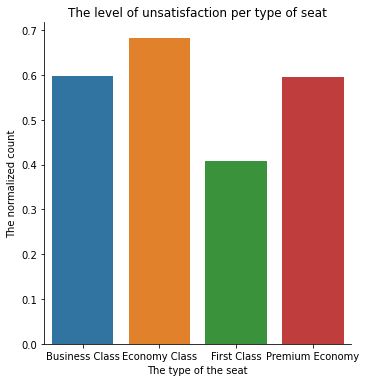

In [822]:
sns.catplot(x='seat_type', y='normalized_count', data=neg_df, kind='bar')
plt.title('The level of unsatisfaction per type of seat')
plt.xlabel('The type of the seat')
plt.ylabel('The normalized count')
plt.show()

The visual shows us that the class with the highest level of dissatisfaction is the "economy class".

#### 4. The type of seat with the highest level of satisfaction


In [823]:

# Getting the dataframe
pos_df = pd.DataFrame(df_BA[df_BA.sentiment == 'positive'].groupby(['seat_type'])['sentiment'].count()).reset_index()

# normalizing using the number of examples for each class

# normlized count for business class
pos_df.loc[(pos_df["seat_type"] == 'Business Class'), 'normalized_count'] = pos_df.loc[(pos_df["seat_type"] == 'Business Class'), 'sentiment']/num_bus

# normlized count for economy class
pos_df.loc[(pos_df["seat_type"] == 'Economy Class'), 'normalized_count'] = pos_df.loc[(pos_df["seat_type"] == 'Economy Class'), 'sentiment']/num_econ

# normlized count for first class
pos_df.loc[(pos_df["seat_type"] == 'First Class'), 'normalized_count'] = pos_df.loc[(pos_df["seat_type"] == 'First Class'), 'sentiment']/num_first

# normlized count for premium economy 
pos_df.loc[(pos_df["seat_type"] == 'Premium Economy'), 'normalized_count'] = pos_df.loc[(pos_df["seat_type"] == 'Premium Economy'), 'sentiment']/num_prem


# Dropping the old column
pos_df.drop('sentiment', axis=1, inplace=True)



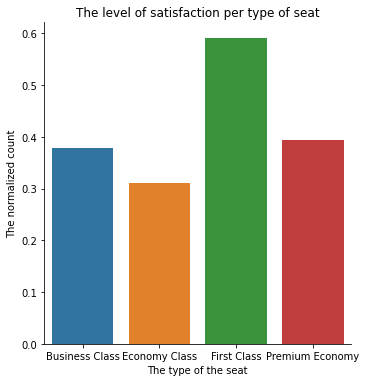

In [824]:
sns.catplot(x='seat_type', y='normalized_count', data=pos_df, kind='bar')
plt.title('The level of satisfaction per type of seat')
plt.xlabel('The type of the seat')
plt.ylabel('The normalized count')
plt.show()

The two visuals show us that the most appreciated class is the "first class", it has the lowest level of dissatisfaction and the highest level of satisfaction.


###  IV. Data analysis in terms of type of traveler 


#### 1. Counting how much cases of each sentiment class we have for each type of traveler.


In [825]:
df_BA.traveler_type.unique()

array(['Solo Leisure', 'Couple Leisure', 'Business', 'Family Leisure'],
      dtype=object)

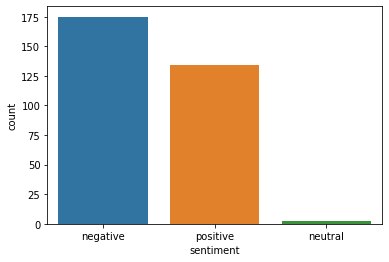

In [826]:
# The case of solo leisure
sns.countplot(x='sentiment', data=df_BA[df_BA['traveler_type'] == 'Solo Leisure'], order=['negative', 'positive', 'neutral'])
plt.show()

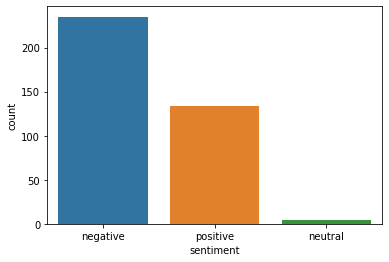

In [827]:
# The case of couple leisure
sns.countplot(x='sentiment', data=df_BA[df_BA['traveler_type'] == 'Couple Leisure'], order=['negative', 'positive', 'neutral'])
plt.show()

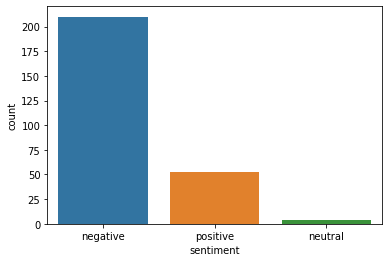

In [828]:
# The case of business
sns.countplot(x='sentiment', data=df_BA[df_BA['traveler_type'] == 'Business'], order=['negative', 'positive', 'neutral'])
plt.show()

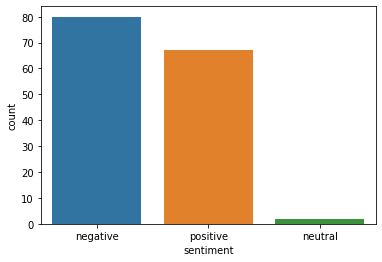

In [829]:
# The case of Family Leisure
sns.countplot(x='sentiment', data=df_BA[df_BA['traveler_type'] == 'Family Leisure'], order=['negative', 'positive', 'neutral'])
plt.show()

#### 2. Negative and positive wordclouds for each type of seat

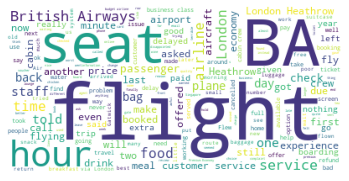

In [830]:
# Wordcloud for Solo leisure
# Negative sentiment.
solo_df = df_BA[(df_BA['traveler_type'] == 'Solo Leisure') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(solo_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

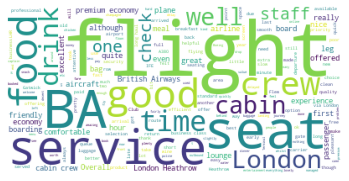

In [831]:
# Wordcloud for Solo leisure
# positive sentiment.
solo_df = df_BA[(df_BA['traveler_type'] == 'Solo Leisure') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(solo_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

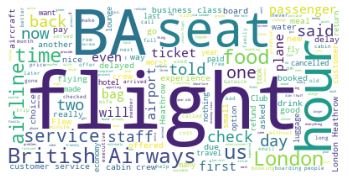

In [832]:
# Wordcloud for family leisure
# negative sentiment.
fam_df = df_BA[(df_BA['traveler_type'] == 'Family Leisure') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(fam_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

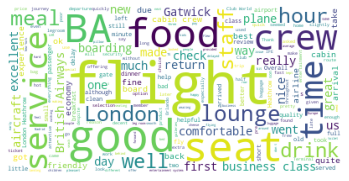

In [833]:
# Wordcloud for family leisure
# positive sentiment.
fam_df = df_BA[(df_BA['traveler_type'] == 'Family Leisure') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(fam_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

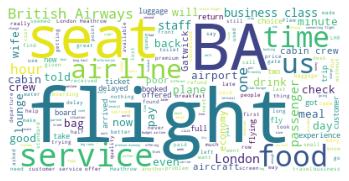

In [834]:
# Wordcloud for couple leisure
# negative sentiment.
fam_df = df_BA[(df_BA['traveler_type'] == 'Couple Leisure') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(fam_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

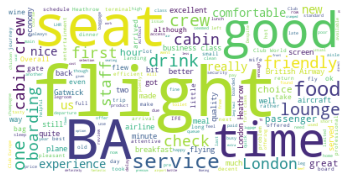

In [835]:
# Wordcloud for couple leisure
# positive sentiment.
fam_df = df_BA[(df_BA['traveler_type'] == 'Couple Leisure') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(fam_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

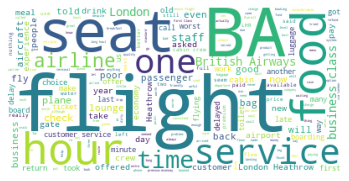

In [836]:
# Wordcloud for Business
# negative sentiment.
fam_df = df_BA[(df_BA['traveler_type'] == 'Business') & (df_BA['sentiment'] == 'negative') ]['review']
words = ' '.join(list(fam_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

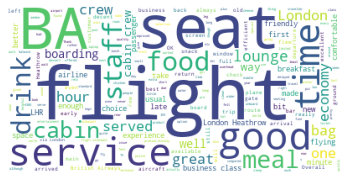

In [837]:
# Wordcloud for Business
# positive sentiment.
fam_df = df_BA[(df_BA['traveler_type'] == 'Business') & (df_BA['sentiment'] == 'positive') ]['review']
words = ' '.join(list(fam_df.values))
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### 3. The type of traveler with the highest level of unsatisfaction


In [838]:

# Getting the dataframe
neg_df_tr = pd.DataFrame(df_BA[df_BA.sentiment == 'negative'].groupby(['traveler_type'])['sentiment'].count()).reset_index()

# normalizing using the number of examples for each type of traveler

# Getting the number of examples for the solo leisure type
num_solo_l = df_BA[df_BA['traveler_type']=='Solo Leisure'].shape[0]

# Getting the number of examples for the couple leisure type
num_couple_l = df_BA[df_BA['traveler_type']=='Couple Leisure'].shape[0]

# Getting the number of examples for the business type
num_bus = df_BA[df_BA['traveler_type']=='Business'].shape[0]

# Getting the number of examples for the family leisure type
num_fam_l = df_BA[df_BA['traveler_type']=='Family Leisure'].shape[0]

# normlized count for solo leisure
neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Solo Leisure'), 'normalized_count_trav'] = neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Solo Leisure'), 'sentiment']/num_solo_l

# normlized count for couple leisure
neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Couple Leisure'), 'normalized_count_trav'] = neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Couple Leisure'), 'sentiment']/num_couple_l

# normlized count for Business
neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Business'), 'normalized_count_trav'] = neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Business'), 'sentiment']/num_bus

# normlized count for Family Leisure 
neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Family Leisure'), 'normalized_count_trav'] = neg_df_tr.loc[(neg_df_tr["traveler_type"] == 'Family Leisure'), 'sentiment']/num_fam_l

neg_df_tr

,traveler_type,sentiment,normalized_count_trav
0,Business,210,0.786517
1,Couple Leisure,235,0.630027
2,Family Leisure,80,0.536913
3,Solo Leisure,175,0.562701


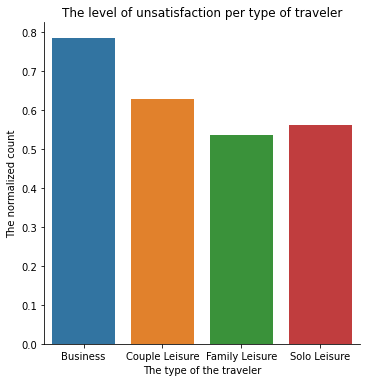

In [839]:
sns.catplot(x='traveler_type', y='normalized_count_trav', data=neg_df_tr, kind='bar')
plt.title('The level of unsatisfaction per type of traveler')
plt.xlabel('The type of the traveler')
plt.ylabel('The normalized count')
plt.show()

#### 4. The type of traveler with the highest level of satisfaction


In [840]:

# Getting the dataframe
pos_df_tr = pd.DataFrame(df_BA[df_BA.sentiment == 'positive'].groupby(['traveler_type'])['sentiment'].count()).reset_index()

# normlized count for solo leisure
pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Solo Leisure'), 'normalized_count_trav'] = pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Solo Leisure'), 'sentiment']/num_solo_l

# normlized count for couple leisure
pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Couple Leisure'), 'normalized_count_trav'] = pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Couple Leisure'), 'sentiment']/num_couple_l

# normlized count for Business
pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Business'), 'normalized_count_trav'] = pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Business'), 'sentiment']/num_bus

# normlized count for Family Leisure 
pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Family Leisure'), 'normalized_count_trav'] = pos_df_tr.loc[(pos_df_tr["traveler_type"] == 'Family Leisure'), 'sentiment']/num_fam_l

pos_df_tr

,traveler_type,sentiment,normalized_count_trav
0,Business,53,0.198502
1,Couple Leisure,134,0.359249
2,Family Leisure,67,0.449664
3,Solo Leisure,134,0.430868


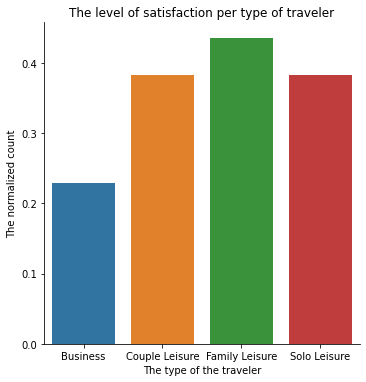

In [787]:
sns.catplot(x='traveler_type', y='normalized_count_trav', data=pos_df_tr, kind='bar')
plt.title('The level of satisfaction per type of traveler')
plt.xlabel('The type of the traveler')
plt.ylabel('The normalized count')
plt.show()

From the two previous visuals, we can see that the most satisfied type of traveler is the "Family Leisure" traveler.
They have the lowest level of dissatisfaction and the highest level of satisfaction.


###  V. A Cross-tabulation of the variables type of seat and type of traveler to aggregate the ratings.

In [684]:
cross_tb = pd.crosstab(index=df_BA['traveler_type'], columns=df_BA['seat_type'], values=df_BA['ratings'],
           aggfunc='median')
cross_tb

seat_type,Business Class,Economy Class,First Class,Premium Economy
traveler_type,,,,
Business,2.0,2.5,3.0,2.5
Couple Leisure,5.0,2.0,7.5,3.0
Family Leisure,6.0,3.0,3.0,3.5
Solo Leisure,6.0,3.0,7.0,7.0


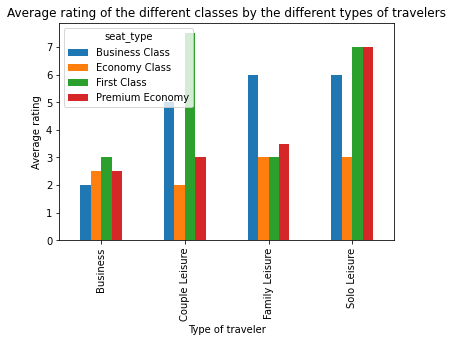

In [687]:
cross_tb.plot(kind='bar')
plt.title('Average rating of the different classes by the different types of travelers')
plt.xlabel('Type of traveler')
plt.ylabel('Average rating')
plt.show()

From the cross table and the visual we can see that :

- Travelers of type "business" are very unsatisfied with all types of seats.
- The first class is poorly rated by travelers of type "family leisure" and highly rated by travelers of types "solo leisure" and "couple leisure".
- The "family leisure" type of travelers appreciate the "business class".
- The "solo leisure" travelers give on average a decent rating for all types of seats, except the "economy class".

